Note: Pyanno currently only works with python 2.7. To import pyanno, also make sure that all the required packages are installed. See the [installation guide](http://docs.enthought.com/uchicago-pyanno/installation.html).

In [1]:
import pyanno
import numpy as np

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data).

In [2]:
from pyanno.annotations import AnnotationsContainer
x = np.loadtxt("data/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [3]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ..., 
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [4]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [5]:
anno.missing_values

[-1]

# Annotation Statistics

Compute Cohen's kappa statistics, which measures the extent of agreement between two annotators. Here, Cohen's kappa statistics for the first two annotators are computed.

In [6]:
from pyanno.measures import cohens_kappa, pairwise_matrix
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

Get the pairwise measure matrix.

In [7]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print (m)

[[ 1.          0.43917037  0.47677621         nan         nan         nan
   0.45819119  0.43381462]
 [ 0.43917037  1.          0.38432922  0.41344423         nan         nan
          nan  0.33643611]
 [ 0.47677621  0.38432922  1.          0.39583333  0.51704894         nan
          nan         nan]
 [        nan  0.41344423  0.39583333  1.          0.34597068  0.4446844
          nan         nan]
 [        nan         nan  0.51704894  0.34597068  1.          0.37938644
   0.43039733         nan]
 [        nan         nan         nan  0.4446844   0.37938644  1.
   0.38341929  0.31214748]
 [ 0.45819119         nan         nan         nan  0.43039733  0.38341929
   1.          0.394806  ]
 [ 0.43381462  0.33643611         nan         nan         nan  0.31214748
   0.394806    1.        ]]


A heatmap visualization:

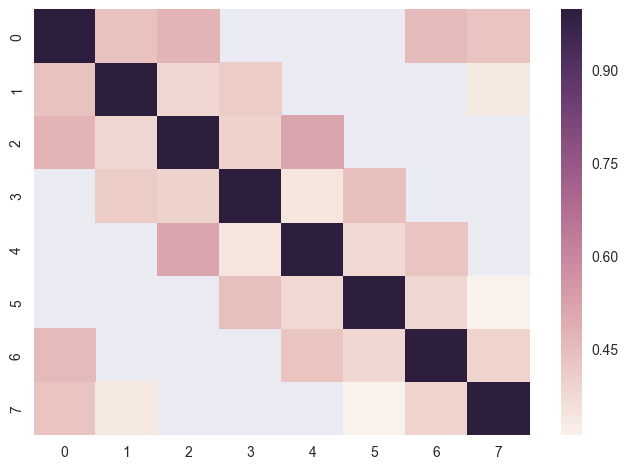

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.heatmap(m)
plt.show()

# Models

Now we use Rzhetsky et al (2009)'s models to make inference about true label classes. Pyanno provides four available models: ModelA, ModelB, ModelBt, and ModelBtLoopDesign. They should give similar results. To estimate the parameters for any models, we first need to create a new model. 

In [ ]:
from pyanno.models import ModelA
# create a new instance of model A, with 4 label classes
model = ModelA.create_initial_state(4)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.89805998  0.71458512  0.73763837  0.92389317  0.71336044  0.64347294
  0.90296637  0.81109879]
-3720.44804183


Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. The estimates should not differ a lot. Note that the parameters here are the accuracy of each annotator.

In [ ]:
model.map(anno.annotations)
print model.theta
print (model.log_likelihood(anno.annotations))

In [ ]:
model = ModelA.create_initial_state(4)
model.mle(anno.annotations)
print model.theta
print (model.log_likelihood(anno.annotations))

After we have model parameters estimated, we can make inference about the true label classes. We can calculate the posterior distribution over the true label classes.

In [ ]:
posterior = model.infer_labels(anno.annotations)
print posterior

sample_posterior_over_accuracy() allows drawing samples from the posterior of the accuracy parameters. We can use such samples to draw credible intervals.

In [ ]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
print samples.mean(axis=0)
print samples.std(axis=0)

Let's try everything again with ModelBt

In [ ]:
from pyanno.models import ModelBt
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

In [ ]:
model.map(anno.annotations)
print model.theta
print (model.log_likelihood(anno.annotations))

In [ ]:
posterior = model.infer_labels(anno.annotations)
print posterior

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [ ]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99,0.75,0.25])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

# Visualization

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipyton notebook. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [ ]:
model = ModelA.create_initial_state(4)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

In [ ]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()